# Functional Encryption - Classification and information leakage
 

### Purpose

We want to train the model on the following task: given two images with the same character, but with two different fonts, can an adversarial model guess with a good accuracy which image has been selected by a challenger which only expose the output of the private model fed with a chosen image?

The first dummy approach is to keep the same network as before, and choose the font the most likely among the two possible according to the collateral model. This is sub-optimal but illustrates the possible performances of the CL model on this distinguish task, which is very common in the cryptography field.

## 1. Parameters and imports


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
torch.set_num_threads(4)

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Some utility functions

In [5]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets():
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    return train_dataset, test_dataset

def get_data_loaders():
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets()

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

## 2. Building resistance

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [6]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [7]:
import torch

In [8]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Phase 1
        if initial_phase: # Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        elif perturbate: # Optimise Freezed(Q) + C
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 2
        if (initial_phase or perturbate): # Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
        elif new_collateral: # Optimise Freezed(Q) + new F
            model.freeze('quad')
            optimizer.zero_grad()
            output_font = model.forward_adv_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 3
        if perturbate: # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
            
            
        if new_collateral:
            loss_char = torch.zeros(1)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [9]:
def test(args, model, test_loader, new_adversary):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            if not new_adversary:
                output = model.forward_char(data)
                pred = output.argmax(1, keepdim=True)
                correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not new_adversary:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [10]:
def build_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        new_adversary = False
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [11]:
path = '../data/models/quadconvnet_part17.pt'
model = QuadConvNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.5
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Model loaded!


# 3. Testing distinguishability

In [12]:
quadratic_model = model
quadratic_model.freeze('quad')

In [13]:
def evaluate_resistance(model, alpha=0):
    """
    Perform a learning phase for the CL model
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        new_adversary = True
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [14]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [15]:
resistance_reports = {}

## 3.1 Fully connected models 

In [16]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = 8
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 15.329388
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.828937
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.644107
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.723098
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.606900
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.608513
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.587319
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.511784
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.648162
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.624784

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2659/10000 (26.59%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.630493
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0

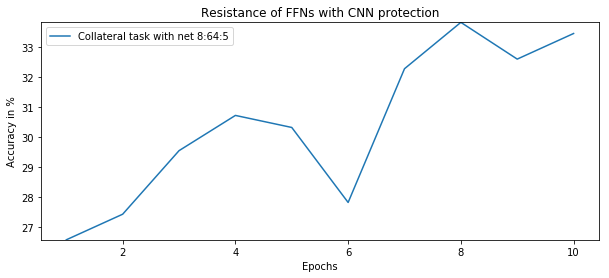

In [17]:
architectures = [[64]]

model = None 
for architecture in architectures:
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


In [18]:
train_dataset, test_dataset = get_datasets()

Training set 60000 items
Testing set  10000 items


In [19]:

def get_pair_distinguish(dataset):
    """Get two samples with arbitrary character but different font"""
    idx = np.random.randint(len(dataset))
    sample1 = dataset[idx]
    labels1 = sample1[1]
    found = False
    while not found:
        idx = np.random.randint(len(dataset))
        sample2 = dataset[idx]
        labels2 = sample2[1]
        # If different font
        if labels1[1] != labels2[1]:
            return sample1, sample2
    

def test_distinguish(model, test_dataset):
    model.eval()
    n_tests = 20000
    correct_font = 0
    acc_by_class = {}
    with torch.no_grad():
        for i in range(n_tests):
            samples = get_pair_distinguish(test_dataset)
            
            beta = np.random.randint(2)
            selected_sample = samples[beta]
            
            data = selected_sample[0]
            target_font = selected_sample[1][1]
            #print('***', target_font)
            
            possible_fonts = [el[1][1].item() for el in samples]
            #print(possible_fonts)
            filter_output = torch.ones(N_FONTS) * -100
            for font in possible_fonts:
                filter_output[font] = 0
            #print(filter_output)
            
            output = model.forward_adv_font(data)
            
            #print(output)
            
            output = output + filter_output
            
            #print(output)
            
            pred = output.argmax(1, keepdim=True)
            
            is_correct = pred.eq(target_font.view_as(pred)).sum().item()
            correct_font += is_correct
            
            sorted(possible_fonts)
            key = '-'.join(map(str, sorted(possible_fonts, reverse=True)))
            if key not in acc_by_class:
                acc_by_class[key] = [0, 0]
            acc_by_class[key][0] += is_correct
            acc_by_class[key][1] += 1
            
            #print('-----')
            
    print('Acc', round(100*correct_font/n_tests, 2), '%')
    
    res = []
    for k, v in acc_by_class.items():
        acc_by_class[k] = (round(100*v[0] / v[1], 2), v[1])
        res.append((k, acc_by_class[k][0], acc_by_class[k][1]))
        
    res = sorted(res, key=lambda x: x[1])
        
    for r in res:
        print(r[0], r[1], '\t', r[2])
        

In [20]:
test_distinguish(model, test_dataset)

Acc 64.8 %
3-0 58.11 	 2017
3-2 60.65 	 1957
4-2 62.02 	 2014
2-0 64.31 	 1880
4-0 65.18 	 2068
3-1 65.2 	 1971
4-3 66.1 	 2065
1-0 66.98 	 2035
2-1 67.59 	 1919
4-1 71.55 	 2074


In [21]:
test_distinguish(model, test_dataset)

Acc 65.44 %
3-0 57.39 	 2016
4-2 63.28 	 1991
2-0 63.39 	 1961
4-0 64.39 	 2053
3-2 64.47 	 1956
4-3 64.64 	 2070
3-1 65.18 	 2108
1-0 70.1 	 1953
2-1 70.36 	 1869
4-1 71.63 	 2023


In [22]:
test_distinguish(model, test_dataset)

Acc 64.22 %
3-0 57.1 	 2107
3-2 60.34 	 1891
4-2 60.35 	 1985
2-0 62.76 	 1939
3-1 63.32 	 2099
4-0 64.31 	 2034
4-3 66.49 	 2116
2-1 66.65 	 1904
1-0 68.4 	 1940
4-1 72.8 	 1985


## 3.2 CNN models

In [23]:
class CNNet2(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet2, self).__init__(quadratic_model)

        self.jc = nn.Linear(8, 784)
            
        self.cv1 = nn.Conv2d(1, 20, 5, 1)
        self.cv2 = nn.Conv2d(20, 50, 5, 1)
        self.ln1 = nn.Linear(4*4*50, 500)
        self.ln2 = nn.Linear(500, N_FONTS)
    
    def conv_font(self, x):
        
        x = self.jc(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.cv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.cv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
         

In [24]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(8, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 4.567784
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.583681
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.589296
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.597754
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.565761
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.584847
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.570419
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.567336
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.559918
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.575880

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2759/10000 (27.59%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.579337
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.355709

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4419/10000 (44.19%)


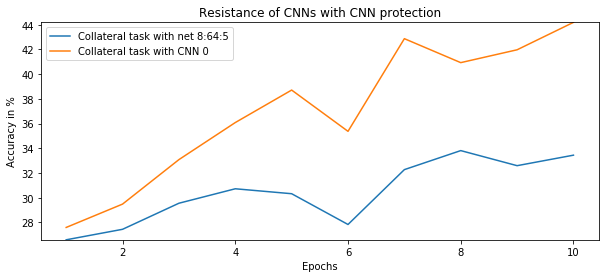

In [25]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
# ,
#    (
#        nn.Conv2d(1, 30, 4, 1),
#        nn.Conv2d(30, 100, 4),
#        nn.Linear(100 * 4 * 4, 1000),
#        nn.Linear(1000, 100),
#        nn.Linear(100, N_FONTS)
#    )
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

In [26]:
model

CNNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=8, bias=True)
  (net_0): Linear(in_features=8, out_features=784, bias=True)
  (net_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (net_2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (net_3): Linear(in_features=800, out_features=500, bias=True)
  (net_4): Linear(in_features=500, out_features=5, bias=True)
)

In [27]:
test_distinguish(model, test_dataset)

Acc 73.88 %
3-0 64.76 	 2043
4-2 68.65 	 2013
4-0 72.02 	 2037
2-0 73.22 	 1908
3-2 74.24 	 1984
2-1 74.88 	 1903
3-1 75.31 	 2009
4-3 75.76 	 2100
1-0 78.93 	 1970
4-1 81.11 	 2033


In [28]:
test_distinguish(model, test_dataset)

Acc 73.94 %
3-0 65.4 	 2029
4-2 69.91 	 2004
4-0 71.81 	 2072
3-1 73.38 	 1961
4-3 73.63 	 2059
2-0 74.45 	 2000
2-1 75.12 	 1873
3-2 75.65 	 1996
1-0 77.83 	 2030
4-1 82.54 	 1976


## Summary

First, recall that the lowest accuracy is 50%, so any result close to 50% means that the resistance is effective. For the FFN, we observe a 67% accuracy, which is not that high and indicates that the collateral model is struggling to distinguish fonts. We have provide the accuracy also for the couples of font distinguished, because all distinction are not of the same difficulty. For example 3-0 which stands for Georgia-serif is hard while 4-1 (cursive-arial) is more easy.
For the CNN, the distinction is made more efficienty, in 3/4 of the times, which seems more problematic. We see that the model orders the couple to distinguish by the same order of difficulty than the FFN.

Here is a representation of the fonts which can help confirming the distinction difficulty reported by the models.

In [29]:
import matplotlib.pyplot as plt

In [30]:
families = ['serif', 'cursive', 'fantasy', 'Georgia', 'arial']

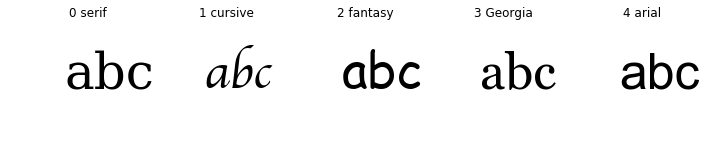

In [31]:
plt.figure(figsize=(12,2))
for i, family in enumerate(families):
    ax = plt.subplot(1, 5, i+1)
    ax.set_title(f'{i} {family}')
    ax.text(0.3, 0.4, 'abc', size=50, family=family)

    # Rm axes, draw and get the rgba shape of the letter
    plt.axis('off')
plt.show()